In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from load_data import *
from load_data_munich import *
from helpers import *

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import shap

Init Plugin
Init Graph Optimizer
Init Kernel


# With decorrelated Variables

In [2]:
# define metric
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  r2 = r2.numpy()
  return r2

#score = make_scorer(R_squared, greater_is_better=True)


In [4]:
np.random.seed(123)
# param_grid = {
#     'n_estimators': [100, 250, 500],
#     'colsample_bytree': [0.1, 0.5, 0.9],
#     'max_depth': [3,10,50],
#     'gamma': [0, 1, 10],
#     'reg_lambda': [0, 1, 10],
#     'subsample': [0.5,0.7,0.9]
# }

param_grid = {
    'n_estimators': [100],
    'colsample_bytree': [0.1],
    'max_depth': [3],
    'gamma': [0],
    'reg_lambda': [0],
    'subsample': [0.5]
}

url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

kf = KFold(n_splits=5)
cv_run = 0
fold_data = {}

# metrics
mse_val_para=[]
mae_val_para=[]
r_val_para = []
parameters = []
for n_estimators in tqdm(param_grid["n_estimators"]):
    for colsample_bytree in tqdm(param_grid["colsample_bytree"]):
        for max_depth in tqdm(param_grid["max_depth"]):
            for gamma in tqdm(param_grid["gamma"]):
                for reg_lambda in tqdm(param_grid["reg_lambda"]):
                    for subsample in tqdm(param_grid["subsample"]):
                        parameters.append([n_estimators, colsample_bytree, max_depth, gamma, reg_lambda, subsample])
                        mse_para = []
                        mae_para = []
                        r_para = []                            
                        c = 0                       
                        
                        for t, v in tqdm(kf.split(X_train), desc = "FOLD", total = 5):
                            # Model
                            params = {
                                'n_estimators': n_estimators,
                                'colsample_bytree': colsample_bytree,
                                'max_depth': max_depth,
                                'gamma': gamma,
                                'reg_lambda': reg_lambda,
                                'subsample': subsample
                                }
                            model_fold = xgb.XGBRegressor(**params)
                            
                            # Data
                            if cv_run > 0:
                                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
                            else:
                                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = t, val_idx = v)
                            
                            # Fit
                            model_fold.fit(X_train_kf, y_train_kf)
                            
                            # Metrics
                            #y_tr_pred = model.predict(X_train_kf)
                            y_val_pred = model_fold.predict(X_val_kf)
                            y_test_pred = model_fold.predict(X_test)
                            
                            #mse_tr = mean_squared_error(X_train_kf, y_tr_pred)
                            mse_val = mean_squared_error(y_val_kf, y_val_pred)
                            #mse_test = mean_squared_error(y_test, y_test_pred)
                        
                            #mae_tr = mean_absolute_error(X_train_kf, y_tr_pred)
                            mae_val = mean_absolute_error(y_val_kf, y_val_pred)
                            #mae_test = mean_absolute_error(y_test, y_test_pred)  
                            
                            #r_tr = model_fold.score(X_train_kf, y_tr_pred)
                            r_val = R_squared(y_val_kf, y_val_pred)
                            r_test = R_squared(y_test, y_test_pred)  
                                                        
                            # print("FOLD ",c)
                            # print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
                            # print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
                            # print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
                            
                            # save mse, mae, r2 of fold
                            mse_para.append(mse_val)
                            mae_para.append(mae_val)
                            r_para.append(r_val)
                            
                            # save fold data
                            if cv_run == 0:
                                fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
                            c += 1
                            print(r_test)

                        cv_run += 1
                        mse_val_para.append(np.nanmean(np.array(mse_para)))
                        mae_val_para.append(np.nanmean(np.array(mae_para)))
                        r_val_para.append(np.nanmean(np.array(r_para)))
                        print("Best R2: ", np.array(r_val).max())
                        print("Best MSE: ", np.array(mse_val).min())



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

FOLD:   0%|          | 0/5 [00:00<?, ?it/s]

------------------------------
Fit listings data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
42 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.


KeyError: "['neighbourhood_cleansed_Dublin_City'] not in index"

In [14]:
l =[[2,3]]
l.append([2,3])
np.stack(l)[:,1]

array([3, 3])

In [16]:
parameters = np.stack(parameters)

In [17]:
results_cor = pd.DataFrame({'n_estimators':parameters[:,0],
                            "colsample_bytree":parameters[:,1],
                            "max_depth":parameters[:,2],
                            "gamma":parameters[:,3],
                            "reg_lambda":parameters[:,4],
                            "subsample":parameters[:,5],
                            "MSE": mse_val_para,
                            "MAE": mae_val_para,
                            "R2": r_val_para}
    )

ValueError: All arrays must be of the same length

In [ ]:
# gridsearch 
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit=score,
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred
  
  

In [33]:
np.random.seed(123)
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.1, 0.5, 0.9],
    'max_depth': [3,10,50],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'subsample': [0.5,0.7,0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

NameError: name 'X_test' is not defined

In [7]:
model.best_score_

0.665197381001297

In [8]:
model.best_params_

{'colsample_bytree': 0.9,
 'gamma': 1,
 'max_depth': 3,
 'n_estimators': 500,
 'reg_lambda': 10,
 'subsample': 0.9}

In [41]:
model.param_grid

{'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

In [21]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
np.random.seed(123)
kf = KFold(n_splits=5)
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
X_train, _ = train_test_split(listings, random_state = 123, test_size = test_split)

c = 1
for t, v in kf.split(X_train, y_train):
    X_train, X_test, X_val, y_train, y_test, y_val = load_data_cv(train_idx = t, val_idx = v)
    # X_train_tmp = X_train.iloc[t,:]
    # y_train_tmp = y_train[t]
    
    # X_val_tmp = X_train.iloc[v,:]
    # y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1

FOLD  1
Train:  0.8024456880055812 0.08809023175192375 0.22325297005565686
Validation:  0.6423473600046352 0.094263637312724 0.2245718485880479
Test:  0.6330447219569217 0.14690261330545543 0.2835577124912234
FOLD  2
Train:  0.7953263603347384 0.08892993349532169 0.2230763069241064
Validation:  0.6603565751680566 0.09090720014649831 0.22527800253532715
Test:  0.6194419855806591 0.14690261330545543 0.2835577124912234
FOLD  3
Train:  0.7946432824407905 0.08970126902968946 0.22354618970217843
Validation:  0.6719172925478007 0.08782226723273953 0.22339965968109463
Test:  0.6171689313330095 0.14690261330545543 0.2835577124912234
FOLD  4
Train:  0.7921310503810065 0.09063479115267047 0.22408803460629453
Validation:  0.7005910162878157 0.08408642069538616 0.2212312596410821
Test:  0.6242977467212724 0.14690261330545543 0.2835577124912234
FOLD  5
Train:  0.7988693687377773 0.08927144159972301 0.22362080660336459
Validation:  0.650774660998177 0.08954238642045838 0.22310105155487905
Test:  0.62

In [42]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1
    if c == 5:
        break

FOLD  1
Train:  0.8024456880055812 0.08809023175192375 0.22325297005565686
Validation:  0.6423473600046352 0.094263637312724 0.2245718485880479
Test:  0.6330447219569217 0.14690261330545543 0.2835577124912234
FOLD  2
Train:  0.7953263603347384 0.08892993349532169 0.2230763069241064
Validation:  0.6603565751680566 0.09090720014649831 0.22527800253532715
Test:  0.6194419855806591 0.14690261330545543 0.2835577124912234
FOLD  3
Train:  0.7946432824407905 0.08970126902968946 0.22354618970217843
Validation:  0.6719172925478007 0.08782226723273953 0.22339965968109463
Test:  0.6171689313330095 0.14690261330545543 0.2835577124912234
FOLD  4
Train:  0.7921310503810065 0.09063479115267047 0.22408803460629453
Validation:  0.7005910162878157 0.08408642069538616 0.2212312596410821
Test:  0.6242977467212724 0.14690261330545543 0.2835577124912234


In [355]:
X_train_no,X_test_no,_,_,_,_ = load_data(for_dendro=True, standardize=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

In [20]:
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_no.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_no[i].values.reshape((X_test_no[i].values.shape[0],1,1))
    
    return values

In [260]:
X_test_no.loc[:,["bedrooms_1", "bedrooms_2", "accommodates", "beds", "room_type_Entire_home/apt", "room_type_Private_room",
                     "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                     "property_type_Entire_residential_home", "property_type_Entire_rental_unit", "property_type_Others"]].mean()

bedrooms_1                               0.688433
bedrooms_2                               0.180970
accommodates                             3.024254
beds                                     1.826493
room_type_Entire_home/apt                0.498134
room_type_Private_room                   0.490672
bath_number_1                            0.675373
bath_number_2                            0.279851
bath_kind_Shared                         0.244403
bath_kind_Private                        0.152985
bath_kind_Normal                         0.602612
property_type_Entire_residential_home    0.139925
property_type_Entire_rental_unit         0.250000
property_type_Others                     0.552239
dtype: float64

In [364]:
X_test_no["accommodates"].argmin()

8

In [369]:
print(X_test_no.loc[[8,588],["bedrooms_1", "bedrooms_2", "accommodates", "beds", "room_type_Entire_home/apt", "room_type_Private_room",
                     "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                     "property_type_Entire_residential_home", "property_type_Entire_rental_unit", "property_type_Others"]].T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  8   &  588 \\
\midrule
bedrooms\_1                            &  1.0 &  0.0 \\
bedrooms\_2                            &  0.0 &  1.0 \\
accommodates                          &  1.0 &  6.0 \\
beds                                  &  1.0 &  2.0 \\
room\_type\_Entire\_home/apt             &  0.0 &  1.0 \\
room\_type\_Private\_room                &  1.0 &  0.0 \\
bath\_number\_1                         &  1.0 &  1.0 \\
bath\_number\_2                         &  0.0 &  0.0 \\
bath\_kind\_Shared                      &  0.0 &  0.0 \\
bath\_kind\_Private                     &  1.0 &  0.0 \\
bath\_kind\_Normal                      &  0.0 &  1.0 \\
property\_type\_Entire\_residential\_home &  0.0 &  1.0 \\
property\_type\_Entire\_rental\_unit      &  0.0 &  0.0 \\
property\_type\_Others                  &  1.0 &  0.0 \\
\bottomrule
\end{tabular}



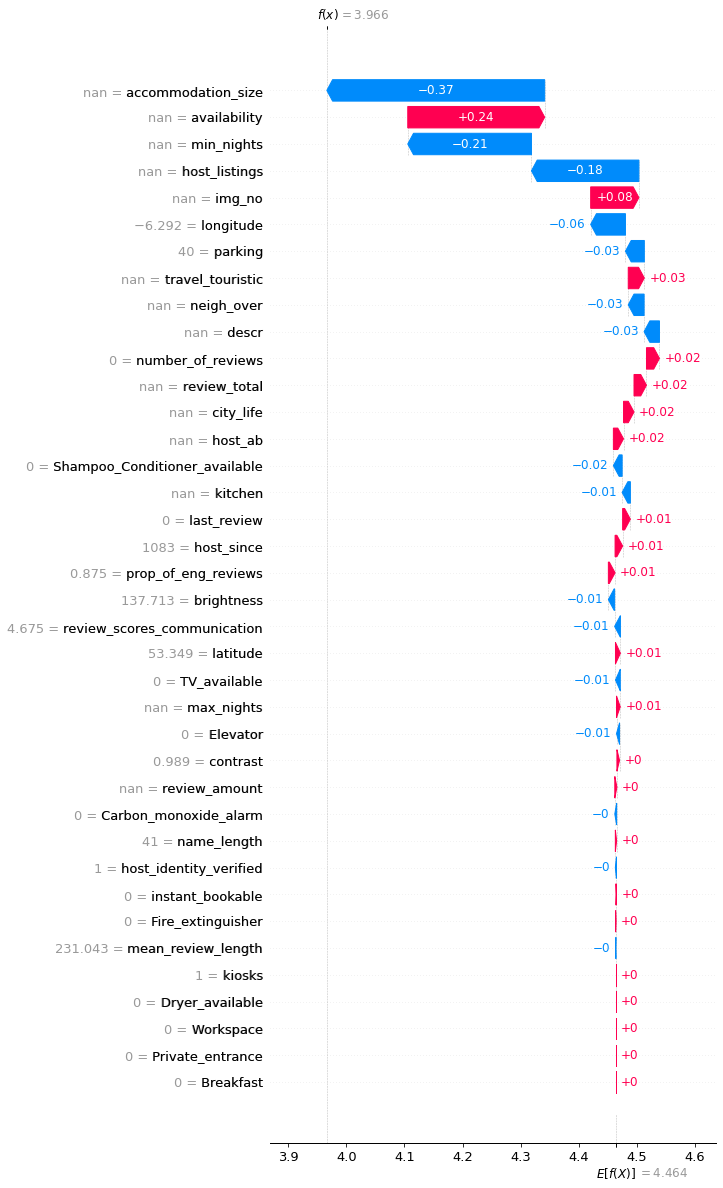

In [365]:
explainer = shap.Explainer(model_fold)
shap_values = explainer(X_test)
shap_values = get_aggr_shap(shap_values)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[8], max_display = 50)

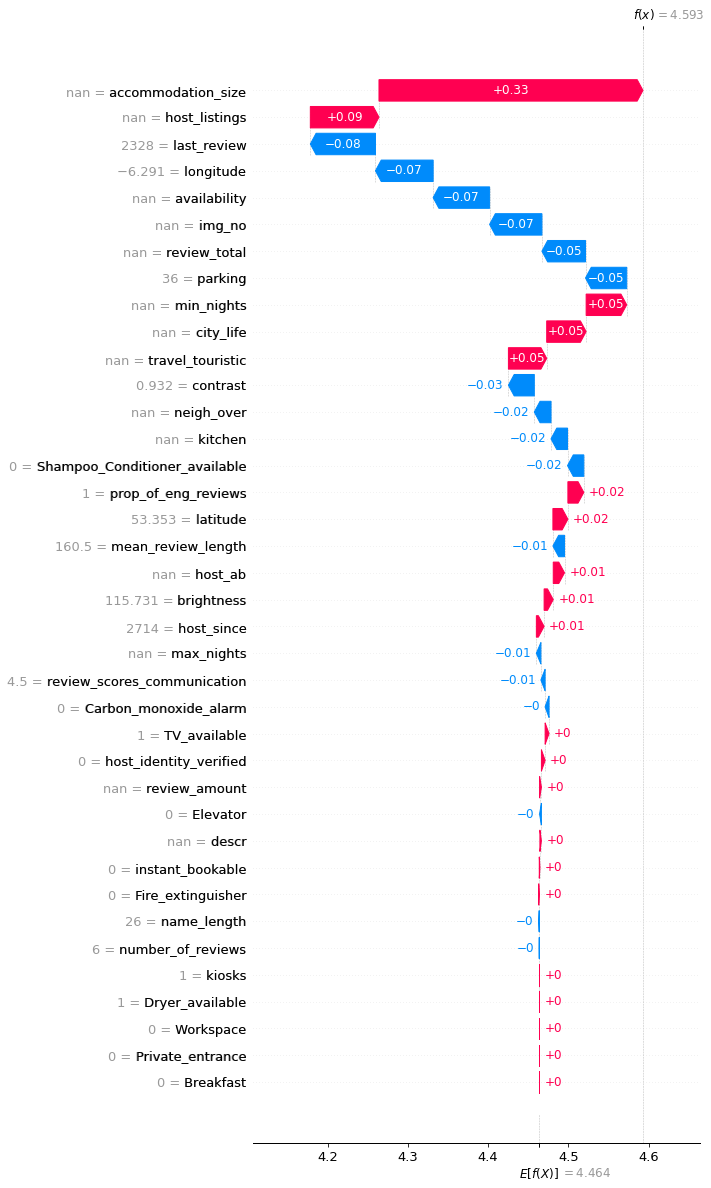

In [370]:


# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[588], max_display = 50)

In [311]:
X_test_no.shape

(1321, 149)

All-NaN slice encountered


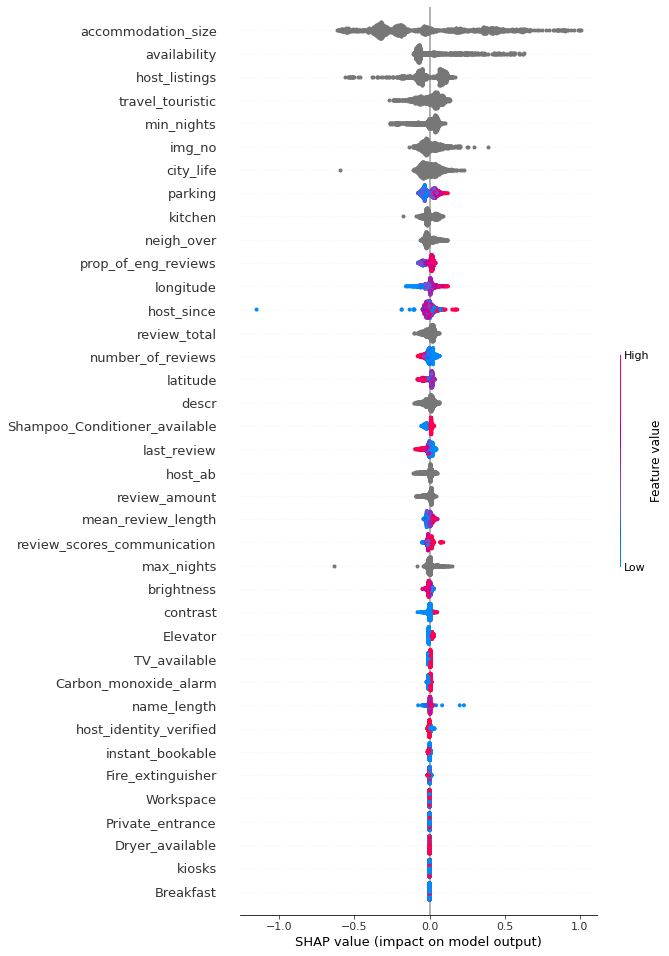

In [371]:
shap.plots.beeswarm(shap_values, max_display=50)


## Adjusted $R^2$

In [372]:
1 - (1-model_fold.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.6045239439171288

## Save best model

In [373]:
model_fold.save_model("xgBoost_models/model_pca.json")

In [15]:
# load
opt_param = {'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

model_new = xgb.XGBRegressor(**opt_param)
model_new.load_model("xgBoost_models/model_pca.json")

## Munich Data

In [16]:
X_train, X_munich, y_train, y_munich = load_data_munich()

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds_west', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 

In [17]:
model_new.score(X_munich, y_munich)

0.19438849222835775

In [18]:
_, X_munich_no, _, _ = load_data_munich(for_dendro=False, standardize=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds_west', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 

In [22]:
def get_aggr_shap_munich(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_munich_no.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_munich_no[i].values.reshape((X_munich_no[i].values.shape[0],1,1))
    
    return values

All-NaN slice encountered


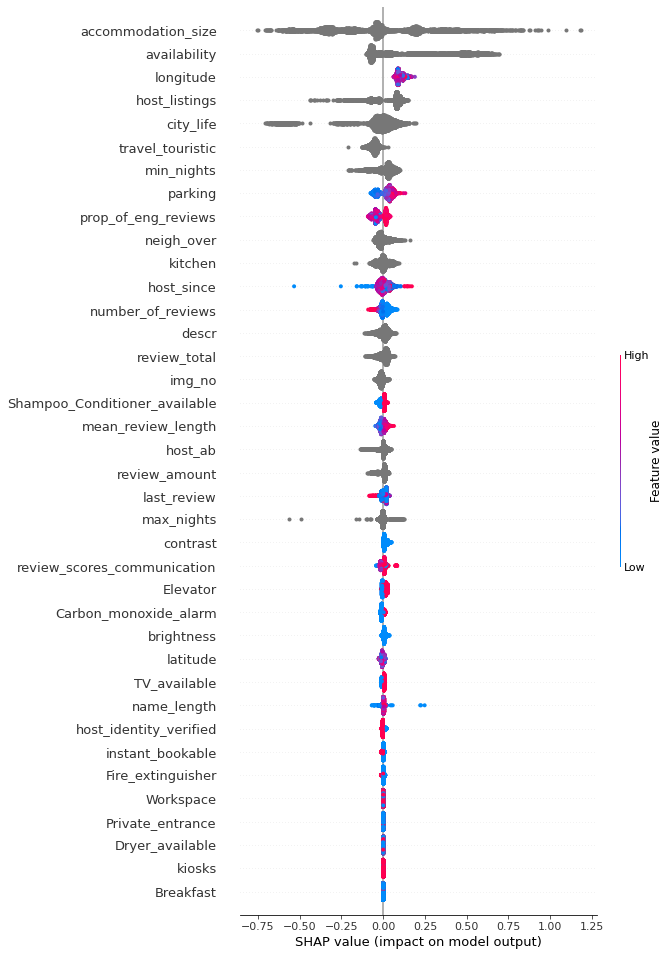

In [27]:
explainer = shap.Explainer(model_new)
shap_values = explainer(X_munich)
shap_values = get_aggr_shap_munich(shap_values)
shap.plots.beeswarm(shap_values, max_display=50)

# Without decorrelation

In [33]:
# Load data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(for_dendro=True)


------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

In [34]:
X_train = pd.concat((X_train,X_val)).reset_index(drop = True)
y_train = pd.concat((y_train,y_val)).reset_index(drop = True)

In [4]:
# define metric
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  r2 = r2.numpy()
  return r2

score = make_scorer(R_squared, greater_is_better=True)


In [5]:
# gridsearch 
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit=score,
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred
  
  

In [ ]:
np.random.seed(123)
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.1, 0.5, 0.9],
    'max_depth': [3,10,50],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'subsample': [0.5,0.7,0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

In [7]:
model.best_score_

0.673327555758427

In [8]:
model.best_params_

{'colsample_bytree': 0.9,
 'gamma': 1,
 'max_depth': 3,
 'n_estimators': 250,
 'reg_lambda': 10,
 'subsample': 0.9}

In [9]:
model.param_grid

{'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

In [10]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1

FOLD  1
Train:  0.8000034003376095 0.09007778405636183 0.22420899748659193
Validation:  0.6439319851512803 0.09921301902952188 0.23133229340516065
Test:  0.6446739036416631 0.13819285628816727 0.27178597673810795
FOLD  2
Train:  0.7946156772550887 0.09200051177124043 0.22613532763837105
Validation:  0.6797523444695457 0.09152753449469675 0.22363240928953562
Test:  0.6547068004620189 0.13819285628816727 0.27178597673810795
FOLD  3
Train:  0.793393049471754 0.0930699726314646 0.22628378225244797
Validation:  0.6838607597954997 0.08724723163854868 0.2230359544607448
Test:  0.6452068323281086 0.13819285628816727 0.27178597673810795
FOLD  4
Train:  0.7909456018733578 0.09285526923700367 0.22573116955812353
Validation:  0.7032062915863875 0.08810644955423502 0.22524744593991514
Test:  0.6466713345919665 0.13819285628816727 0.27178597673810795
FOLD  5
Train:  0.7926936310109163 0.09152536889952487 0.22581281180940305
Validation:  0.6558863977894221 0.09342855542455981 0.22492072318291134
Test

In [35]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1
    if c == 5:
        break

FOLD  1
Train:  0.8000034003376095 0.09007778405636183 0.22420899748659193
Validation:  0.6439319851512803 0.09921301902952188 0.23133229340516065
Test:  0.6446739036416631 0.13819285628816727 0.27178597673810795
FOLD  2
Train:  0.7946156772550887 0.09200051177124043 0.22613532763837105
Validation:  0.6797523444695457 0.09152753449469675 0.22363240928953562
Test:  0.6547068004620189 0.13819285628816727 0.27178597673810795
FOLD  3
Train:  0.793393049471754 0.0930699726314646 0.22628378225244797
Validation:  0.6838607597954997 0.08724723163854868 0.2230359544607448
Test:  0.6452068323281086 0.13819285628816727 0.27178597673810795
FOLD  4
Train:  0.7909456018733578 0.09285526923700367 0.22573116955812353
Validation:  0.7032062915863875 0.08810644955423502 0.22524744593991514
Test:  0.6466713345919665 0.13819285628816727 0.27178597673810795


In [13]:
X_train_no,X_test_no,_,_,_,_ = load_data(for_dendro=True, standardize=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

In [14]:
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_no.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_no[i].values.reshape((X_test_no[i].values.shape[0],1,1))
    
    
    
    return values

In [43]:
explainer = shap.Explainer(model_fold)
shap_values = explainer(X_test)
#shap_values = get_aggr_shap(shap_values)
shap_values.data = X_test_no

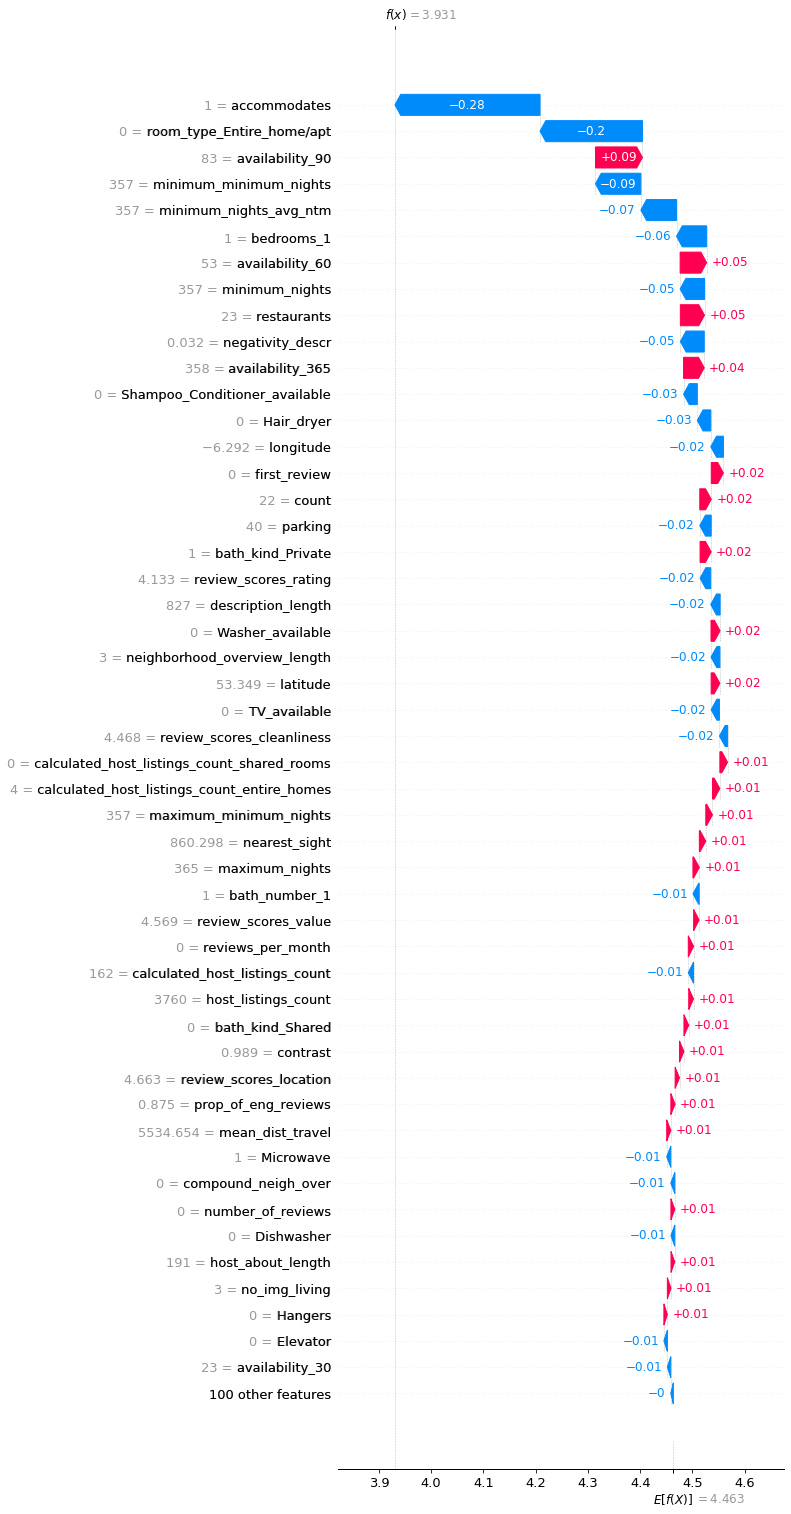

In [44]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[8], max_display = 50)

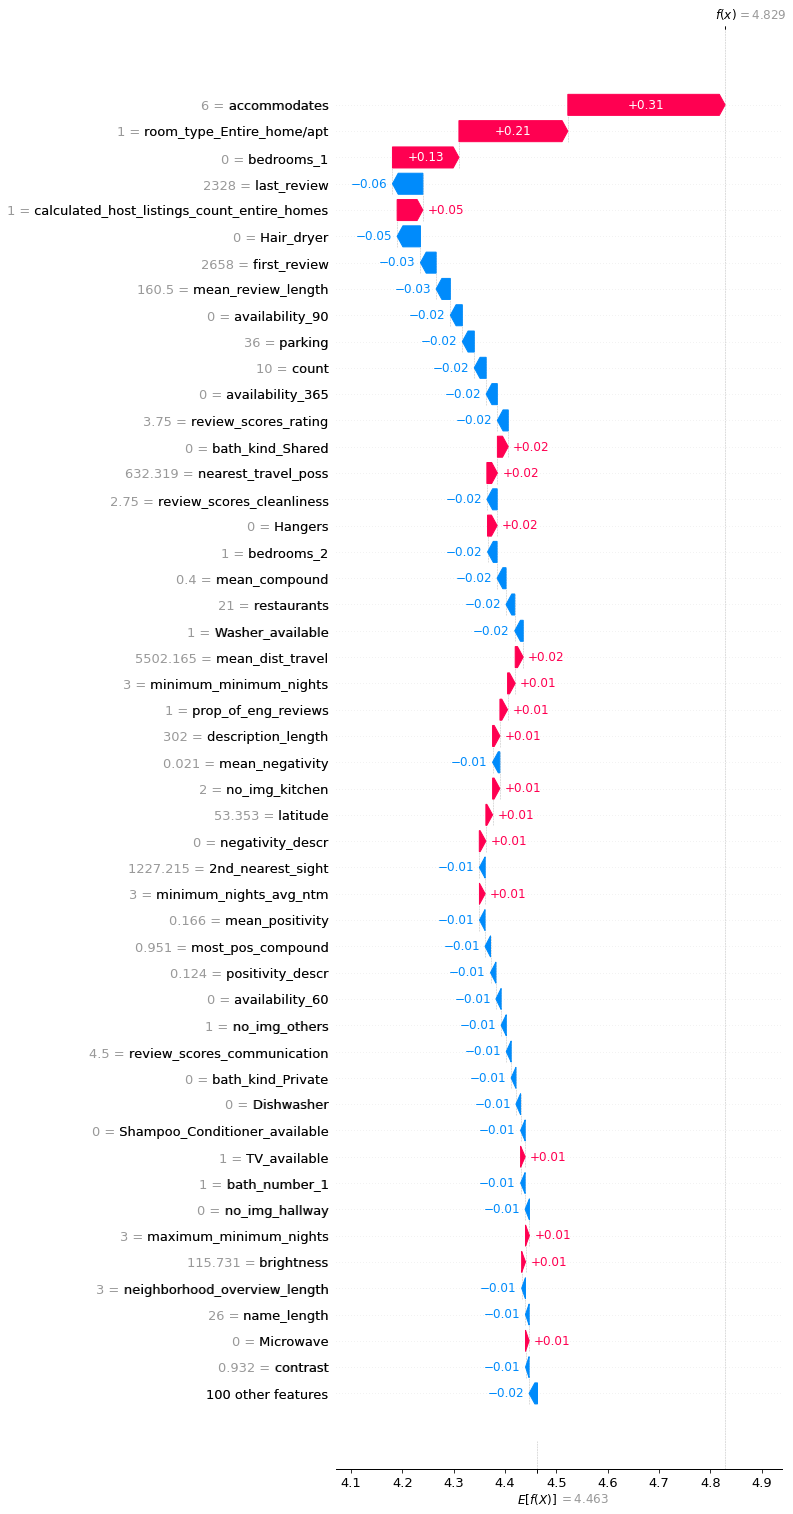

In [45]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[588], max_display = 50)

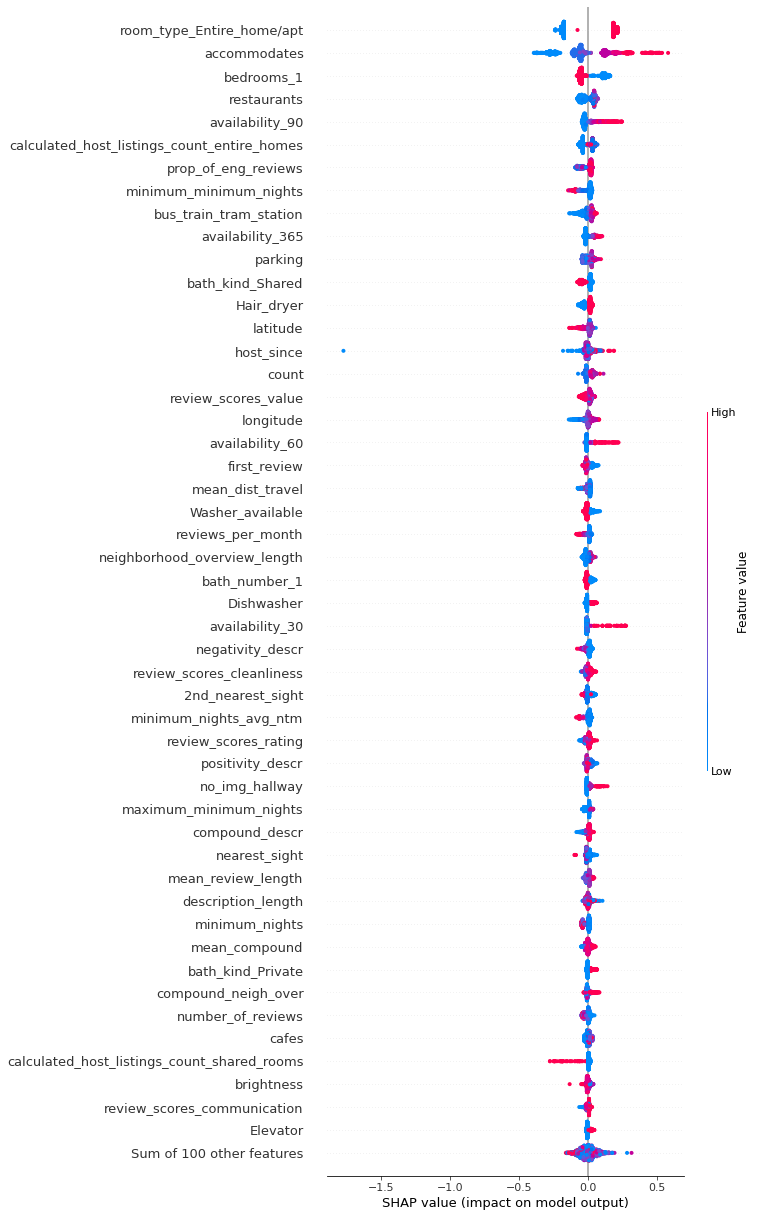

In [46]:
shap.plots.beeswarm(shap_values, max_display=50)


In [23]:
1 - (1-model_fold.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.6017132038099025

### Save best model

In [24]:
model_fold.save_model("xgBoost_models/model_nopca.json")

In [5]:
# load
opt_param = {'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

model_new = xgb.XGBRegressor(**opt_param)
model_new.load_model("xgBoost_models/model_nopca.json")

### Munich Data

In [8]:
X_train, X_munich, y_train, y_munich = load_data_munich(for_dendro=True)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds_west', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds

In [9]:
model_new.score(X_munich, y_munich)

-0.10631639311893903

In [11]:
_, X_munich_no, _, _ = load_data_munich(for_dendro=True, standardize=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds_west', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds

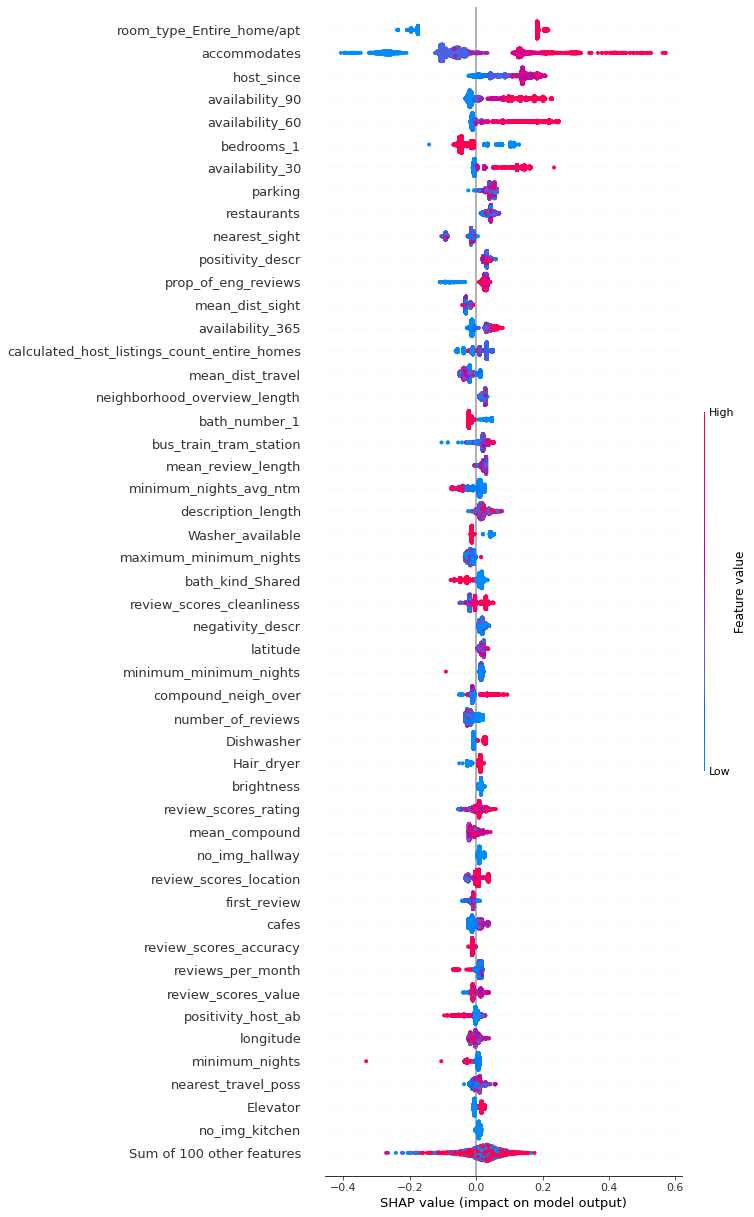

In [14]:
explainer = shap.Explainer(model_new)
shap_values = explainer(X_munich)
#shap_values = get_aggr_shap(shap_values)
shap_values.data = X_munich_no
shap.plots.beeswarm(shap_values, max_display=50)
